## 1. Выравнивание ридов RNA-Seq

In [1]:
%%capture

!hisat2-build ref.fa ref.fa.index

!hisat2 -p 4 -x ref.fa.index -1 SRR453566_1.fastq.gz -2 SRR453566_2.fastq.gz | samtools sort > SRR453566_mapped.bam

## 2. Оценка количества экспрессирующихся генов

In [2]:
!featureCounts -a data/7/genes.gtf -o data/7/feature_counts.txt data/7/SRR453566_mapped.bam


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                           o SRR453566_mapped.bam                           ||
||                                                                            ||
||             Output file : feature_counts.txt                               ||
||                 Summary : feature_counts.txt.summary          

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font='serif')

In [4]:
genes = pd.read_csv('data/7/feature_counts.txt', skiprows=1, sep='\t')
genes['FPKM'] = genes['SRR453566_mapped.bam'] / genes['SRR453566_mapped.bam'].sum() / genes['Length'] * 1_000_000_000

genes['TPM'] = genes['SRR453566_mapped.bam'] / genes['Length']
genes['TPM'] = genes['TPM'] / genes['TPM'].sum() * 1_000_000

genes

,Geneid,Chr,Start,End,Strand,Length,SRR453566_mapped.bam,FPKM,TPM
0,YDL248W,IV,1802,2953,+,1152,584,58.936447,49.905108
1,YDL247W-A,IV,3762,3836,+,75,10,15.501093,13.125727
2,YDL247W,IV,5985,7814,+,1830,18,1.143523,0.968291
3,YDL246C,IV,8683,9756,-,1074,15,1.623718,1.374902
4,YDL245C,IV,11657,13360,-,1704,42,2.865519,2.426411
...,...,...,...,...,...,...,...,...,...
7121,tV(UAC)Q,Mito,78533,78608,+,76,0,0.000000,0.000000
7122,Q0275,Mito,79213,80022,+,810,0,0.000000,0.000000
7123,tM(CAU)Q2,Mito,85035,85112,+,78,0,0.000000,0.000000
7124,RPM1,Mito,85295,85777,+,483,0,0.000000,0.000000


#### TMP value distibution

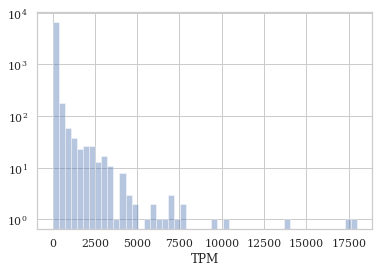

In [5]:
sns.distplot(genes['TPM'], kde=False, hist_kws={'log':True})

#### Count genes with significant value of TMP

In [6]:
genes[genes.TPM > 1]

,Geneid,Chr,Start,End,Strand,Length,SRR453566_mapped.bam,FPKM,TPM
0,YDL248W,IV,1802,2953,+,1152,584,58.936447,49.905108
1,YDL247W-A,IV,3762,3836,+,75,10,15.501093,13.125727
3,YDL246C,IV,8683,9756,-,1074,15,1.623718,1.374902
4,YDL245C,IV,11657,13360,-,1704,42,2.865519,2.426411
5,YDL244W,IV,16204,17226,+,1023,16,1.818310,1.539675
...,...,...,...,...,...,...,...,...,...
7068,YAR071W,I,225460,226863,+,1404,91,7.535254,6.380562
7069,YAR073W,I,227742,228953,+,1212,53,5.083898,4.304849
7074,15S_rRNA,Mito,6546,8194,+,1649,20,1.410045,1.193972
7092,Q0130,Mito,46723,46953,+,231,8,4.026258,3.409280


With lowest TMP threshhold (1) we got **6247 expressed genes**.

## 3. Сборка de novo

In [7]:
%%capture

!rnaspades.py -1 SRR453566_1.fastq.gz -2 SRR453566_2.fastq.gz -o rnaspades_results -t 16 -m 16

In [8]:
%%capture

!rnaQUAST.py --transcripts rnaspades_results/transcripts.fasta --reference ref.fa --gtf genes.gtf

As we can see in rnaQUAST report, rnaSpades predicted only **3825** against **6247** genes in hiStat alignment.